In [1]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Input rotation and topology files.
agegrid_dir = "/home/ben/Dropbox/USyd/GPlates/SampleData/Rasters/M2020_AgeGrids/"
input_directory = "/home/ben/Dropbox/USyd/GPlates/SampleData/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/"

rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model = pygplates.RotationModel(rotation_filenames)

coastlines = input_directory+"StaticGeometries/Coastlines/Global_coastlines_2019_v1_low_res.shp"
continents = input_directory+"StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp"
static_polygons = input_directory+"StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2019_v1.shp"
COBs = input_directory+"StaticGeometries/COBLineSegments/Global_EarthByte_GeeK07_COBLineSegments_2019_v1.shp"

topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)


# Tessellate the subduction zones to 0.5 degrees.
tessellation_threshold_radians = np.radians(0.05)

extent_globe = [-180,180,-90,90]
agegrid_filename = "Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:.0f}.nc"

In [3]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

Get a raster

In [4]:
import matplotlib.image as mpimg

In [5]:
topo_filename = "/mnt/5841d321-3ba0-461b-990f-27a016f8689f/GeoData/Rasters/Topography/Topography.jpg"
topo = mpimg.imread(topo_filename)

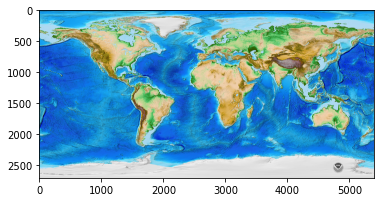

In [6]:
plt.imshow(topo)

In [7]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)
graster = gplately.Raster(model, array=topo[:,:,0], extent=[-180,180,-90,90])
graster.resample(5, 5, overwrite=True)

array([[ 14.        ,  14.        ,  17.        , ...,  17.        ,
         17.        ,  13.        ],
       [ 71.52777778,  62.97260802,  55.12037037, ...,  22.33487654,
         42.04128086,  65.75      ],
       [ 60.5       ,  51.95524691,  29.02777778, ...,  48.        ,
         60.87654321,  62.77777778],
       ...,
       [171.16666667, 222.94598765, 224.        , ..., 224.        ,
        224.98688272, 170.16666667],
       [245.75      , 141.96180556, 118.72067901, ..., 137.50694444,
        234.81944444, 246.75      ],
       [225.        , 224.        , 225.        , ..., 224.        ,
        225.        , 224.        ]])

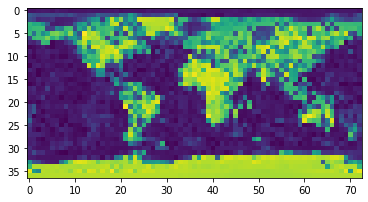

In [8]:
plt.imshow(graster.data)

In [9]:
new_raster = graster.reconstruct(100)

/home/ben/.local/lib/python3.7/site-packages/stripy/spherical.py:1444: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos((extxyz * vertxyz).sum(axis=1))


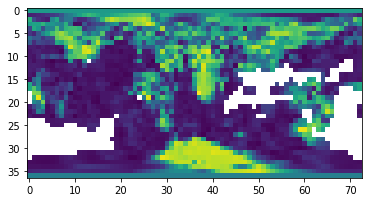

In [10]:
plt.imshow(new_raster)